## Resolução desafio manutenção preditiva Indicium:
### Para a resolução desse desafio foi utilizado como guia o método CRISP-DM (Cross Industry Standard Process for Data Mining), método cíclico para resolução de problemas de mineração de dados, o qual é formado por seis etapas:
    1. Entendimento do problema de negócio
    2. Entendimento dos dados
    3. Preparação dos dados
    4. Modelagem
    5. Avaliação
    6. Implantação

In [138]:
# Importação das Bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
import plotly.express as px
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import math
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_validate
from sklearn.metrics import confusion_matrix, recall_score, precision_score, classification_report

### 1. Entendimento do problema de negócio

<p>A manutenção preditiva se trata de uma atividade de extrema importância para as indústrias, pois contribui para evitar acidentes, paradas indesejadas na produção, aumentar a vida útil dos equipamentos e evitar gastos desnecessários, haja vista que esta modalidade de manutenção busca prever as falhas nas máquinas fazendo com que elas recebam manutenção apenas quando elas realmente precisem.</p> 
Para a previsão de falhas nas máquinas tem-se a disposição dados históricos de sensores e pretende-se entregar a solução da seguinte maneira:<br/>
        <ul>
        <li>Análises gráficas, estatísticas e hípoteses formuladas;</li>
        <li>Tratamento dos dados conforme necessidades encontradas nas análises;</li>
        <li>Implementação e avaliação dos algoritmos de aprendizagem de máquina;</li>
        </ul>


### 2. Entendimento dos dados

O conjunto de dados consiste em 10.000 pontos de dados armazenados como linhas com 8 variáveis em colunas:<br/>
    <ol>
    <li>UID: identificador único que varia de 1 a 10000</li>
    <li>product ID: consistindo em uma letra L, M ou H para baixo (50% de todos os produtos), médio (30%) e alto (20%) como variantes de qualidade do produto e um número de série específico da variante</li>
    <li>type: apenas o tipo de produto L, M ou H da coluna 2</li>
    <li>air temperature [K]: gerada usando um processo de passeio aleatório posteriormente normalizado para um desvio padrão de 2 K em torno de 300 K</li>
    <li>process temperature [K]: gerada usando um processo de passeio aleatório normalizado para um desvio padrão de 1 K, adicionado à temperatura do ar mais 10 K.</li>
    <li>rotational speed [rpm]: calculada a partir de uma potência de 2860 W, sobreposta com um ruído normalmente distribuído</li>
    <li>torque [Nm]: os valores de torque são normalmente distribuídos em torno de 40 Nm com DP = 10 Nm e sem valores negativos.</li>
    <li>tool wear [min]: As variantes de qualidade H/M/L adicionam 5/3/2 minutos de desgaste da ferramenta à ferramenta utilizada no processo.</li>
    </ol>

Um rótulo de 'falha de máquina' que indica se a máquina falhou neste ponto de dados específico para qualquer um dos modos de falha a seguir é verdadeiro.<br/>
A falha da máquina consiste em cinco modos de falha independentes:<br/> 
    <ol>   
    <li><b>tool wear failure (TWF):</b> a ferramenta será substituída ou falha em um tempo de desgaste da ferramenta selecionado aleatoriamente entre 200 - 240 minutos (120 vezes em nosso conjunto de dados). Neste momento, a ferramenta é substituída 69 vezes e falha 51 vezes (atribuídas aleatoriamente).</li>
    <li><b>heat dissipation failure (HDF):</b> a dissipação de calor causa uma falha no processo, se a diferença entre a temperatura do ar e do processo for inferior a 8,6 K e a velocidade de rotação da ferramenta for inferior a 1380 rpm. Este é o caso de 115 pontos de dados.</li>
    <li><b>power failure (PWF)</b>: o produto do torque e da velocidade de rotação (em rad/s) é igual à energia necessária para o processo. Se esta potência estiver abaixo de 3500 W ou acima de 9000 W, o processo falha, o que ocorre 95 vezes em nosso conjunto de dados.</li>
    <li><b>overstrain failure (OSF):</b> se o produto do desgaste da ferramenta e do torque exceder 11.000 minNm para a variante de produto L (12.000 M, 13.000 H), o processo falha devido à sobrecarga. Isso é verdade para 98 pontos de dados.</li>
    <li><b>random failures (RNF):</b> cada processo tem uma chance de 0,1% de falhar independentemente de seus parâmetros de processo. Este é o caso de apenas 5 pontos de dados, menos do que o esperado para 10.000 pontos de dados em nosso conjunto de dados.Se pelo menos um dos modos de falha acima for verdadeiro, o processo falha e o rótulo 'falha da máquina' é definido como 1. Portanto, não é transparente para o método de aprendizado de máquina qual dos modos de falha causou a falha do processo.</li>
    </ol>

#### 2.1 Coleta dos dados

In [246]:
# Importação da base de dados dos sensores
sensores_treino_df = pd.read_csv(r'desafio_manutencao_preditiva_treino.csv')
sensores_treino_df

,udi,product_id,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type
0,1,M14860,M,298.1,308.6,1551,42.8,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,No Failure
2,5,L47184,L,298.2,308.7,1408,40.0,9,No Failure
3,6,M14865,M,298.1,308.6,1425,41.9,11,No Failure
4,7,L47186,L,298.1,308.6,1558,42.4,14,No Failure
...,...,...,...,...,...,...,...,...,...
6662,9995,L57174,L,298.8,308.3,1634,27.9,12,No Failure
6663,9996,M24855,M,298.8,308.4,1604,29.5,14,No Failure
6664,9997,H39410,H,298.9,308.4,1632,31.8,17,No Failure
6665,9999,H39412,H,299.0,308.7,1408,48.5,25,No Failure


In [140]:
# Salvando uma cópia da base original
df_raw = sensores_treino_df

#### 2.2 Análise geral dos dados

In [141]:
# Checando os tipos de dados
sensores_treino_df.dtypes

udi                        int64
product_id                object
type                      object
air_temperature_k        float64
process_temperature_k    float64
rotational_speed_rpm       int64
torque_nm                float64
tool_wear_min              int64
failure_type              object
dtype: object

In [142]:
# Checando valores nulos
sensores_treino_df.isna().sum()

udi                      0
product_id               0
type                     0
air_temperature_k        0
process_temperature_k    0
rotational_speed_rpm     0
torque_nm                0
tool_wear_min            0
failure_type             0
dtype: int64

In [143]:
# Medidas de estatística descritiva
df_numericas = sensores_treino_df.select_dtypes(include=['int64', 'float64'])
df_numericas.agg(["mean","median","std","min","max","skew","kurtosis","count"]).T.reset_index()

,index,mean,median,std,min,max,skew,kurtosis,count
0,udi,4994.589921,4983.0,2896.125718,1.0,10000.0,0.004917,-1.206180,6667.0
1,air_temperature_k,299.992515,300.0,1.994710,295.3,304.5,0.126800,-0.819938,6667.0
2,process_temperature_k,309.992620,310.0,1.488101,305.7,313.8,0.016152,-0.508652,6667.0
3,rotational_speed_rpm,1537.419529,1503.0,177.182908,1168.0,2886.0,1.952833,7.310365,6667.0
4,torque_nm,40.058512,40.2,9.950804,3.8,76.6,0.011572,0.008249,6667.0
5,tool_wear_min,108.098095,108.0,63.359915,0.0,251.0,0.019810,-1.157345,6667.0


- Com as medidas estatísticas pode-se observar que as colunas <b>"air_temperature_k"</b> e <b>"process_temperature_k"</b> possuem média e mediana praticamente iguais, baixo desvio padrão, baixa diferença entre máximo e mínimo o que indica baixa presença de outliers nessas variáveis.</br>
- Já as colunas <b>"rotational_speed_rpm"</b>, <b>"torque_nm"</b> e <b>"tool_wear_min"</b> possuem maior variabilidade em seus valores conforme verificado pelo desvio padrão com relação a média e as grandes difernças entre os máximos e minimos, indicando maior presença de outliers. Apesar disso a média e a mediana continuam muito próximas mesmo nessas colunas.</br>
- A coluna <b>"rotational_speed_rpm"</b> apesar de a média e a mediana estarem próximas, possui skewness positiva (leve deslocamento à esquerda concentrando a maioria dos dados abaixo da média) e kurtosis positiva também, indicando que a maior parte dos dados encontra-se em torno (mais próximos) da média.</br>
- A coluna <b>"tool_wear_min"</b> possui kurtosis negativa, indicando que os dados estão bem distribuidos ao longo da média.

In [144]:
# Calculando a porcentagem de falhas na base de dados
sensores_treino_df[sensores_treino_df['failure_type'] != 'No Failure'].shape[0]/sensores_treino_df.shape[0]

0.03479826008699565

<b>Pode-se observar que se trata de uma base de dados extremamente desbalanceada, uma vez que apenas 3,48% dos dados representam falhas. Dessa forma talvez seja necessário aplicação de over ou undersampling para melhorar a performance do modelo.</b>

#### 2.3 Análise das variáveis categóricas

In [145]:
# Separando dataset apenas com as variáveis categóricas
df_categoricas = sensores_treino_df.select_dtypes(exclude=['int64', 'float64'])
df_categoricas.head()

,product_id,type,failure_type
0,M14860,M,No Failure
1,L47181,L,No Failure
2,L47184,L,No Failure
3,M14865,M,No Failure
4,L47186,L,No Failure


In [146]:
# Como as colunas "product_id" e type carregam a mesma informação, será usada apeanas 1 delas para análise
df_categoricas = df_categoricas.drop(columns='product_id')
df_categoricas.head()

,type,failure_type
0,M,No Failure
1,L,No Failure
2,L,No Failure
3,M,No Failure
4,L,No Failure


##### Coluna "type"

In [147]:
contagem_tipos_maquinas = df_categoricas.groupby('type').count().reset_index()
contagem_tipos_maquinas.rename(columns= {'failure_type': 'contagem'}, inplace=True)
contagem_tipos_maquinas

,type,contagem
0,H,658
1,L,4022
2,M,1987


In [148]:
#Ativar as linhas de grade nos gráficos para melhorar a visualização
sns.set_style('darkgrid') 

<AxesSubplot:title={'center':'Contagem do tipo de máquinas'}, xlabel='type'>

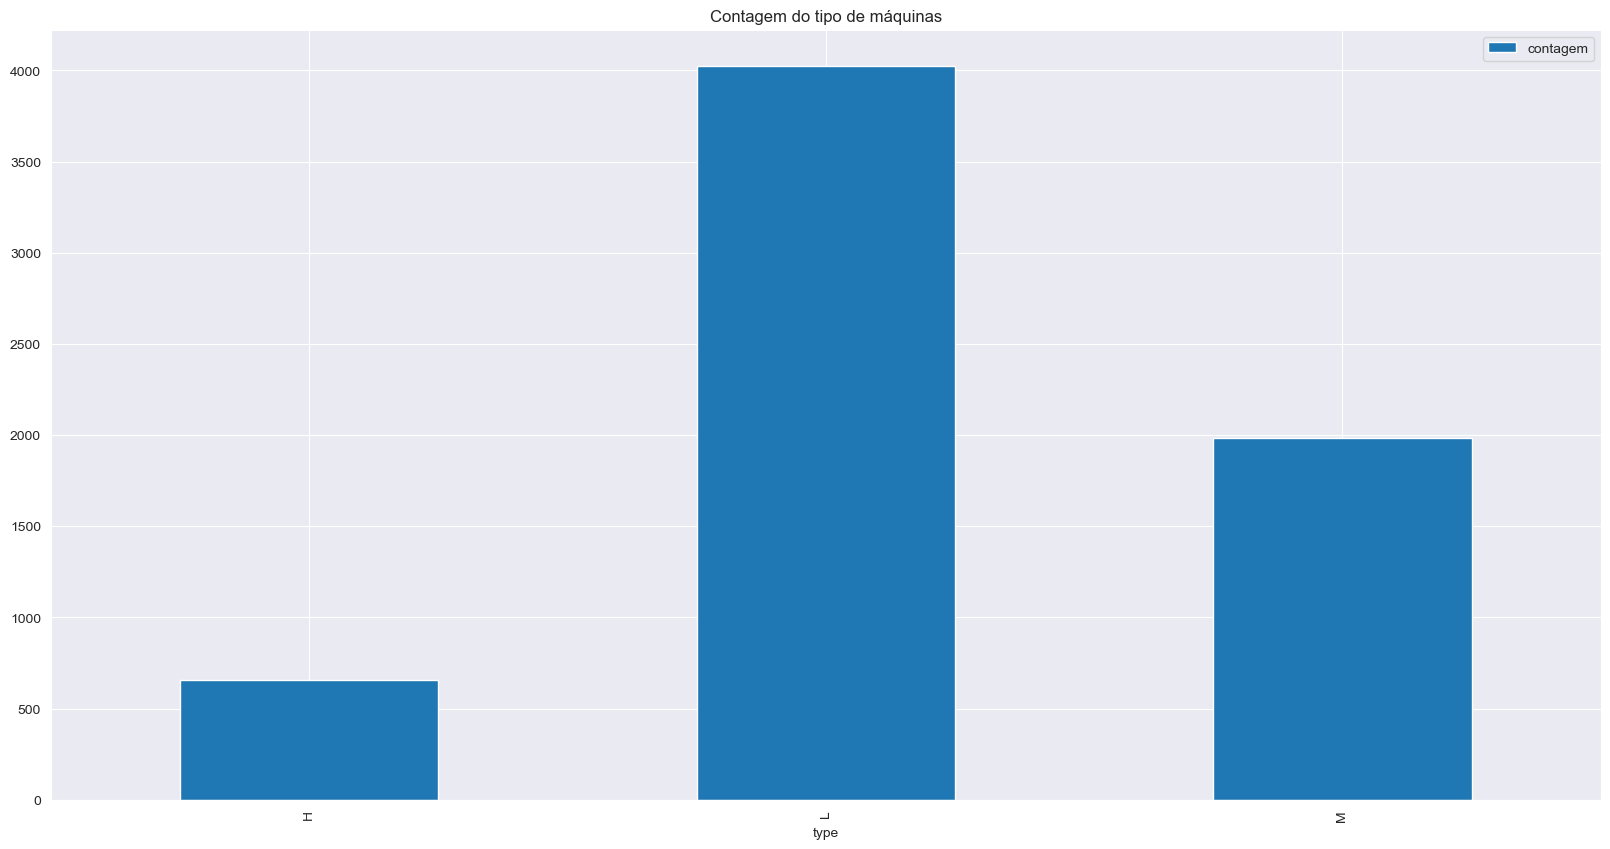

In [149]:
# Plotando gráfico de barras com a contagem dos tipos de máquinas
contagem_tipos_maquinas.plot(kind= 'bar', x= 'type', y='contagem', 
                             figsize= (20,10), title= 'Contagem do tipo de máquinas')

In [150]:
contagem_tipos_maquinas['proporções'] = contagem_tipos_maquinas['contagem']/6667
contagem_tipos_maquinas

,type,contagem,proporções
0,H,658,0.098695
1,L,4022,0.603270
2,M,1987,0.298035


<b> É possível observar que a divisão da base de treino alterou as proporções descritas de 50% - L, 30% - M e 20% - H para aproximadamente 60% - L, 30% - M e 10% - H, o que pode influenciar no treinamento do modelo </b>

##### Coluna "failure_type"

In [151]:
contagem_tipos_falhas = df_categoricas.groupby('failure_type').count().reset_index()
contagem_tipos_falhas.rename(columns= {'type': 'contagem'}, inplace=True)
contagem_tipos_falhas

,failure_type,contagem
0,Heat Dissipation Failure,75
1,No Failure,6435
2,Overstrain Failure,52
3,Power Failure,63
4,Random Failures,12
5,Tool Wear Failure,30


<AxesSubplot:title={'center':'Contagem do tipo de falhas (incluindo não falhas)'}, xlabel='failure_type'>

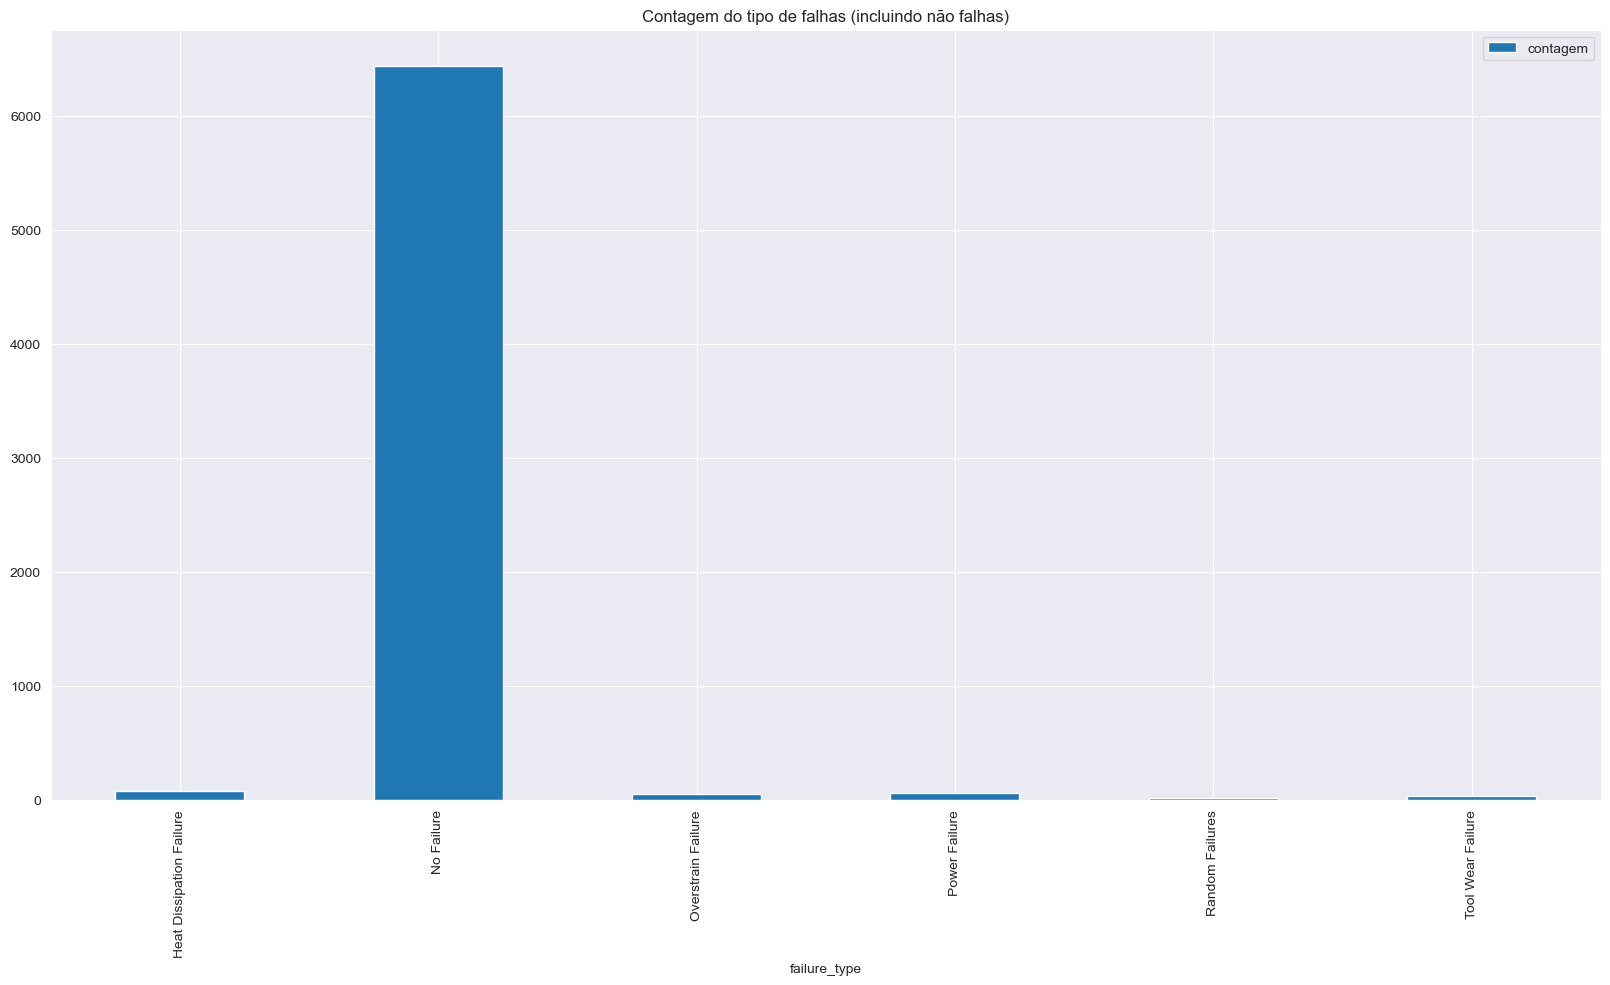

In [152]:
(contagem_tipos_falhas.plot(kind='bar', x= 'failure_type', y='contagem', 
                            figsize = (20,10), title= 'Contagem do tipo de falhas (incluindo não falhas)'))

<b>Como existem muitos registros de "não falhas" será feito um novo gráfico de barras apenas com as categorias de falhas para que se possa visualizar melhor as proporções.

In [153]:
contagem_tipos_apenas_falhas = (df_categoricas[df_categoricas['failure_type'] != 'No Failure'].
groupby('failure_type').count().reset_index())
contagem_tipos_apenas_falhas.rename(columns= {'type': 'contagem'}, inplace=True)
contagem_tipos_apenas_falhas

,failure_type,contagem
0,Heat Dissipation Failure,75
1,Overstrain Failure,52
2,Power Failure,63
3,Random Failures,12
4,Tool Wear Failure,30


<AxesSubplot:title={'center':'Contagem do tipo de falhas (sem não falhas)'}, xlabel='failure_type'>

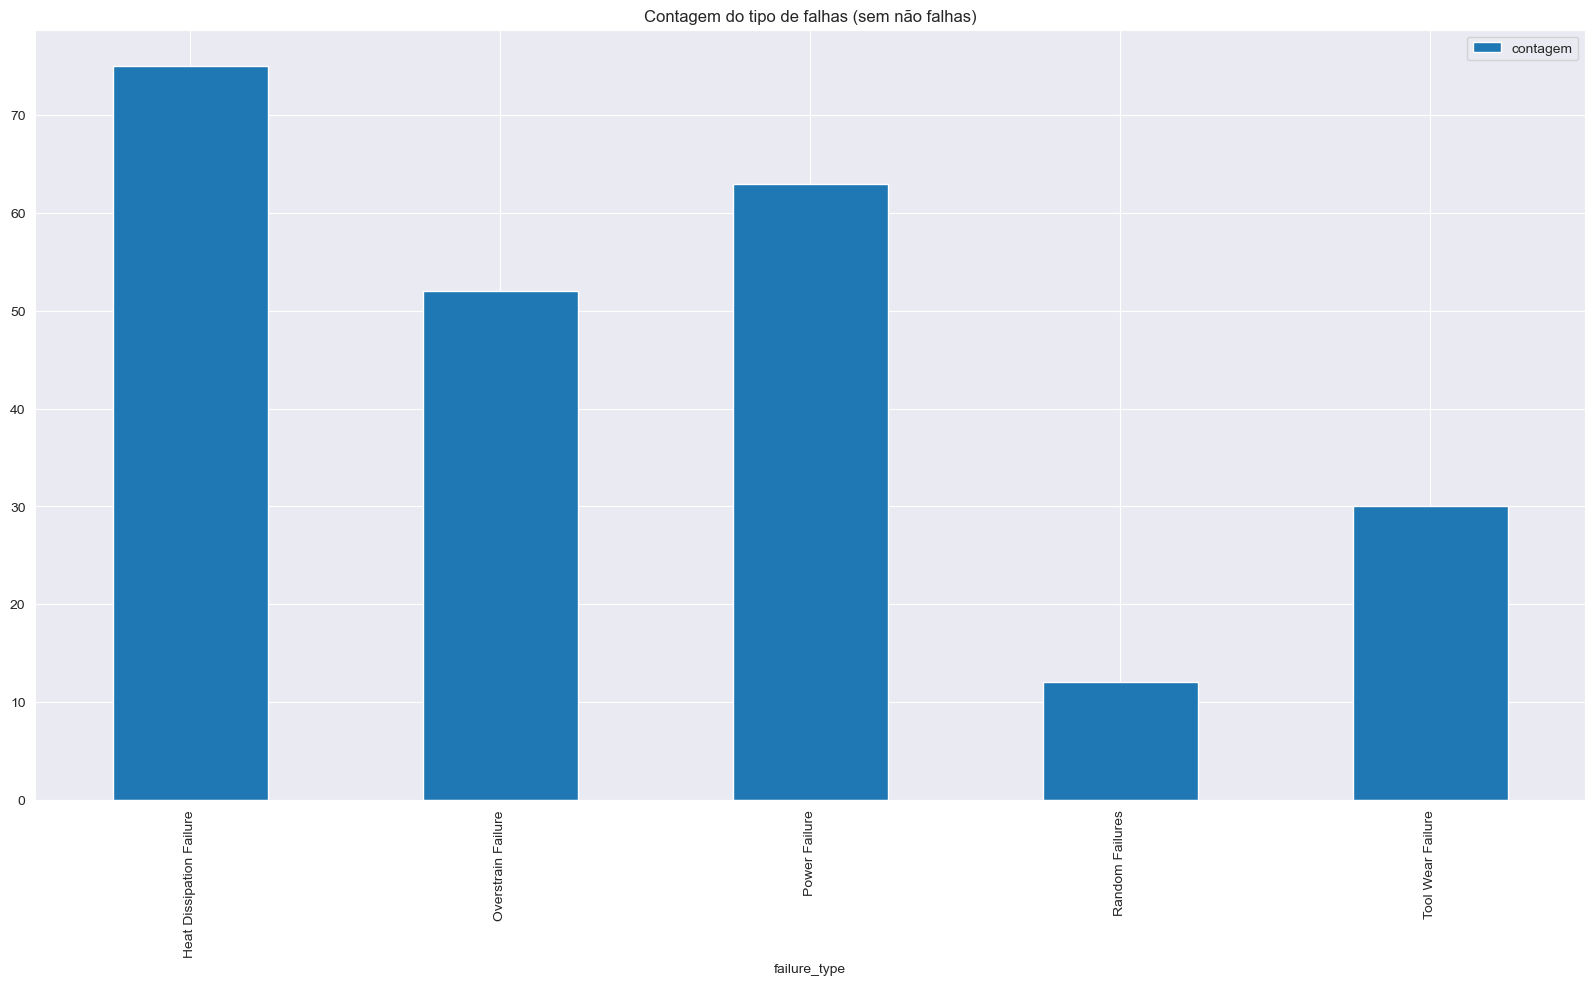

In [154]:
(contagem_tipos_apenas_falhas.plot(kind='bar', x= 'failure_type', y='contagem',
                                   figsize = (20,10), title= 'Contagem do tipo de falhas (sem não falhas)'))

#### 2.3 Variáveis numéricas

In [155]:
# Verificando as colunas separadas apenas com as variáveis numéricas
df_numericas.head()

,udi,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min
0,1,298.1,308.6,1551,42.8,0
1,2,298.2,308.7,1408,46.3,3
2,5,298.2,308.7,1408,40.0,9
3,6,298.1,308.6,1425,41.9,11
4,7,298.1,308.6,1558,42.4,14


In [156]:
# Será excluída a coluna com os números de identificação por não se tratar de um previsor
df_numericas = df_numericas.drop(columns='udi')
df_numericas.head()

,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min
0,298.1,308.6,1551,42.8,0
1,298.2,308.7,1408,46.3,3
2,298.2,308.7,1408,40.0,9
3,298.1,308.6,1425,41.9,11
4,298.1,308.6,1558,42.4,14


In [157]:
def plot_hist(df):
    fig = plt.figure( figsize=(20, 15) )
    specs = gridspec.GridSpec( ncols=2, nrows=math.ceil(df.shape[1]/2), figure=fig )
    for n, i in enumerate(df.columns):
        ax = fig.add_subplot(specs[math.floor(n/2), 0 if (n%2) == 0 else 1])
        df[i].plot(kind = 'hist');
        plt.title(i)

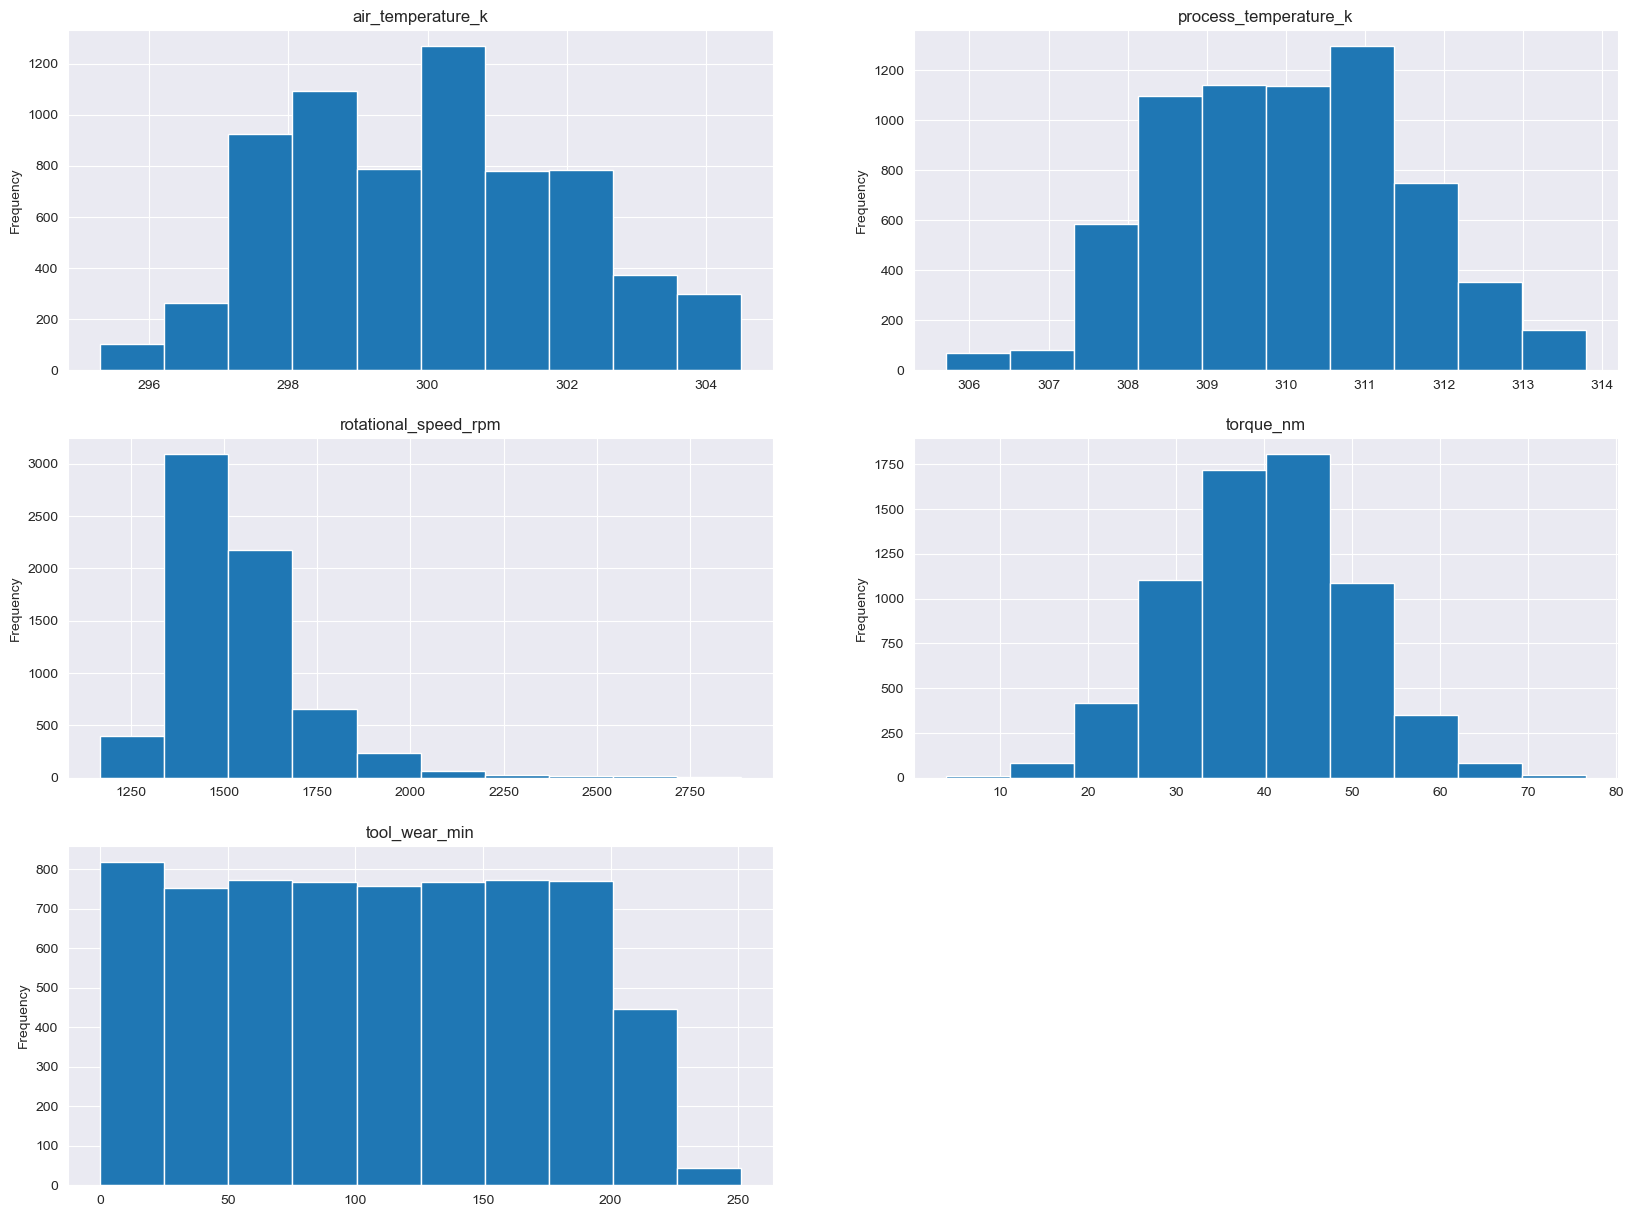

In [158]:
plot_hist(df_numericas)

In [159]:
def plot_line(df):
    fig = plt.figure( figsize=(20, 15) )
    specs = gridspec.GridSpec( ncols=2, nrows=math.ceil(df.shape[1]/2), figure=fig )
    for n, i in enumerate(df.columns):
        ax = fig.add_subplot(specs[math.floor(n/2), 0 if (n%2) == 0 else 1])
        df[i].plot(kind = 'line');
        plt.title(i)

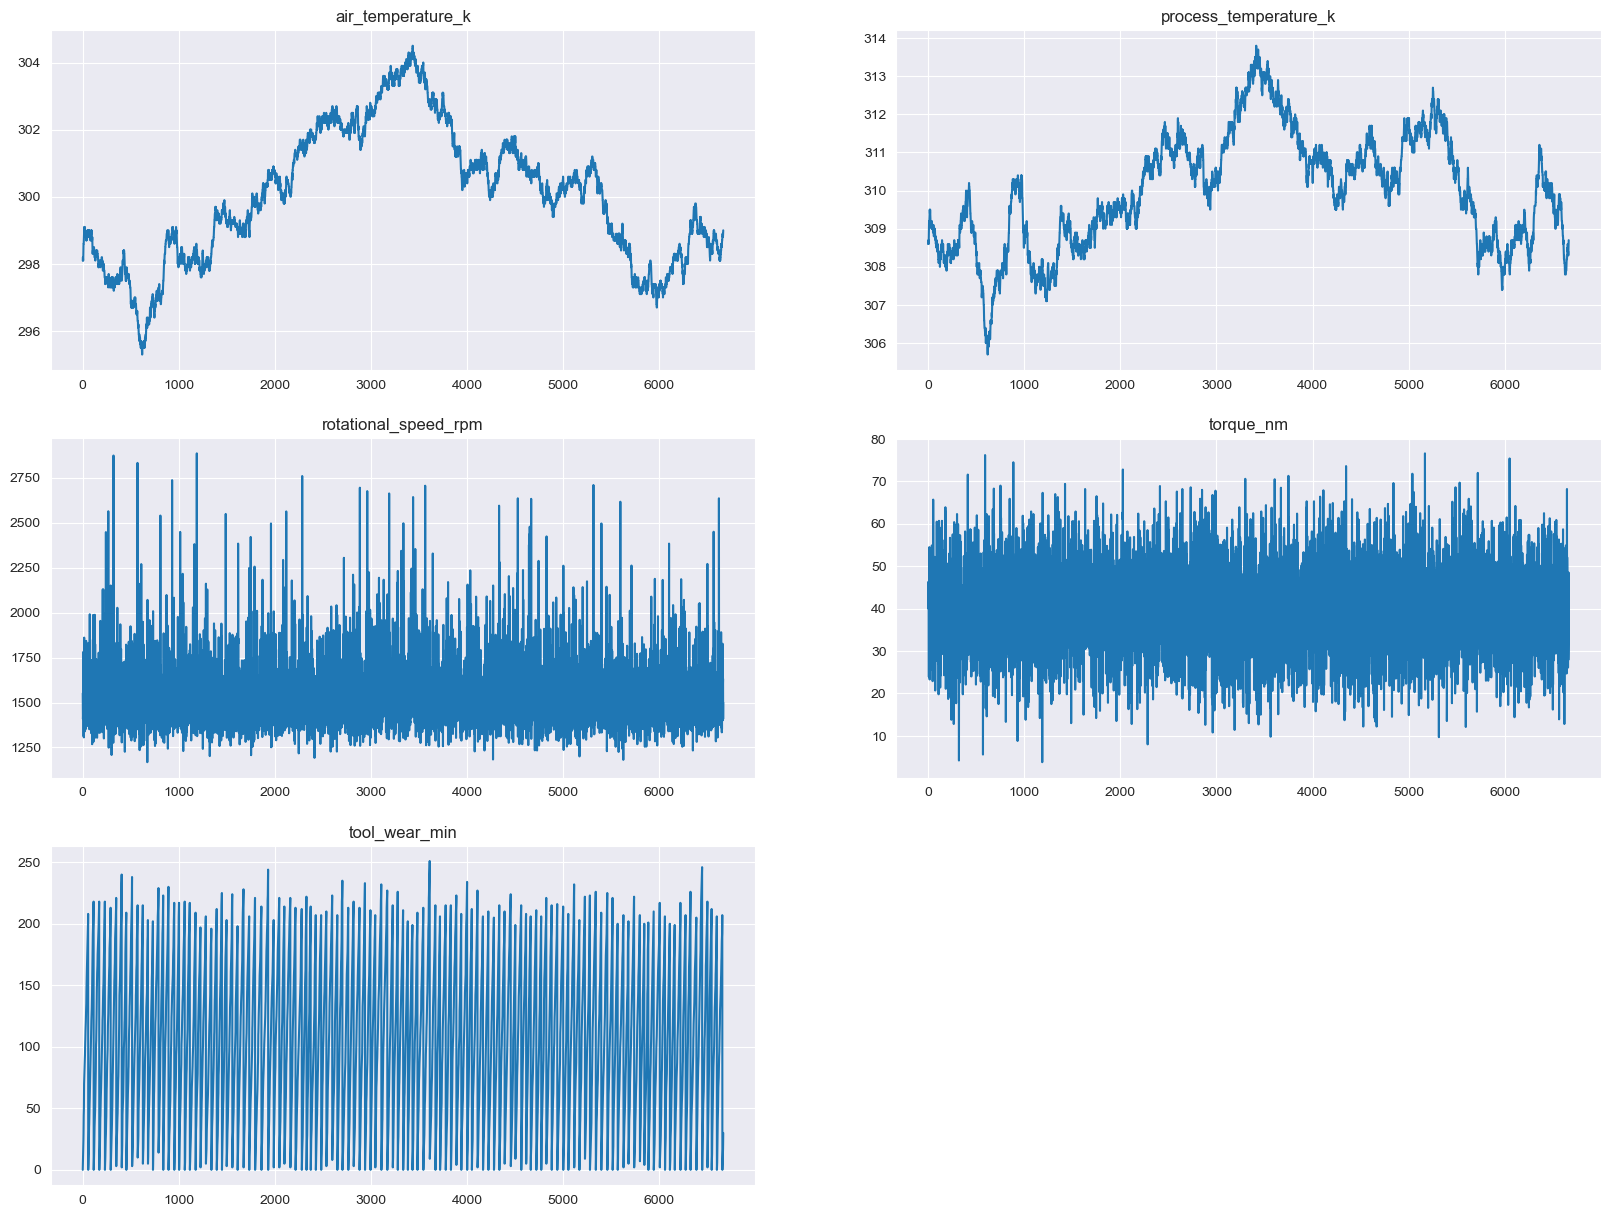

In [160]:
plot_line(df_numericas)

In [161]:
def plot_boxplot(df):
    fig = plt.figure( figsize=(20, 15) )
    specs = gridspec.GridSpec( ncols=2, nrows=math.ceil(df.shape[1]/2), figure=fig )
    for n, i in enumerate(df.columns):
        ax = fig.add_subplot(specs[math.floor(n/2), 0 if (n%2) == 0 else 1])
        df[i].plot(kind = 'box');
        plt.title(i)

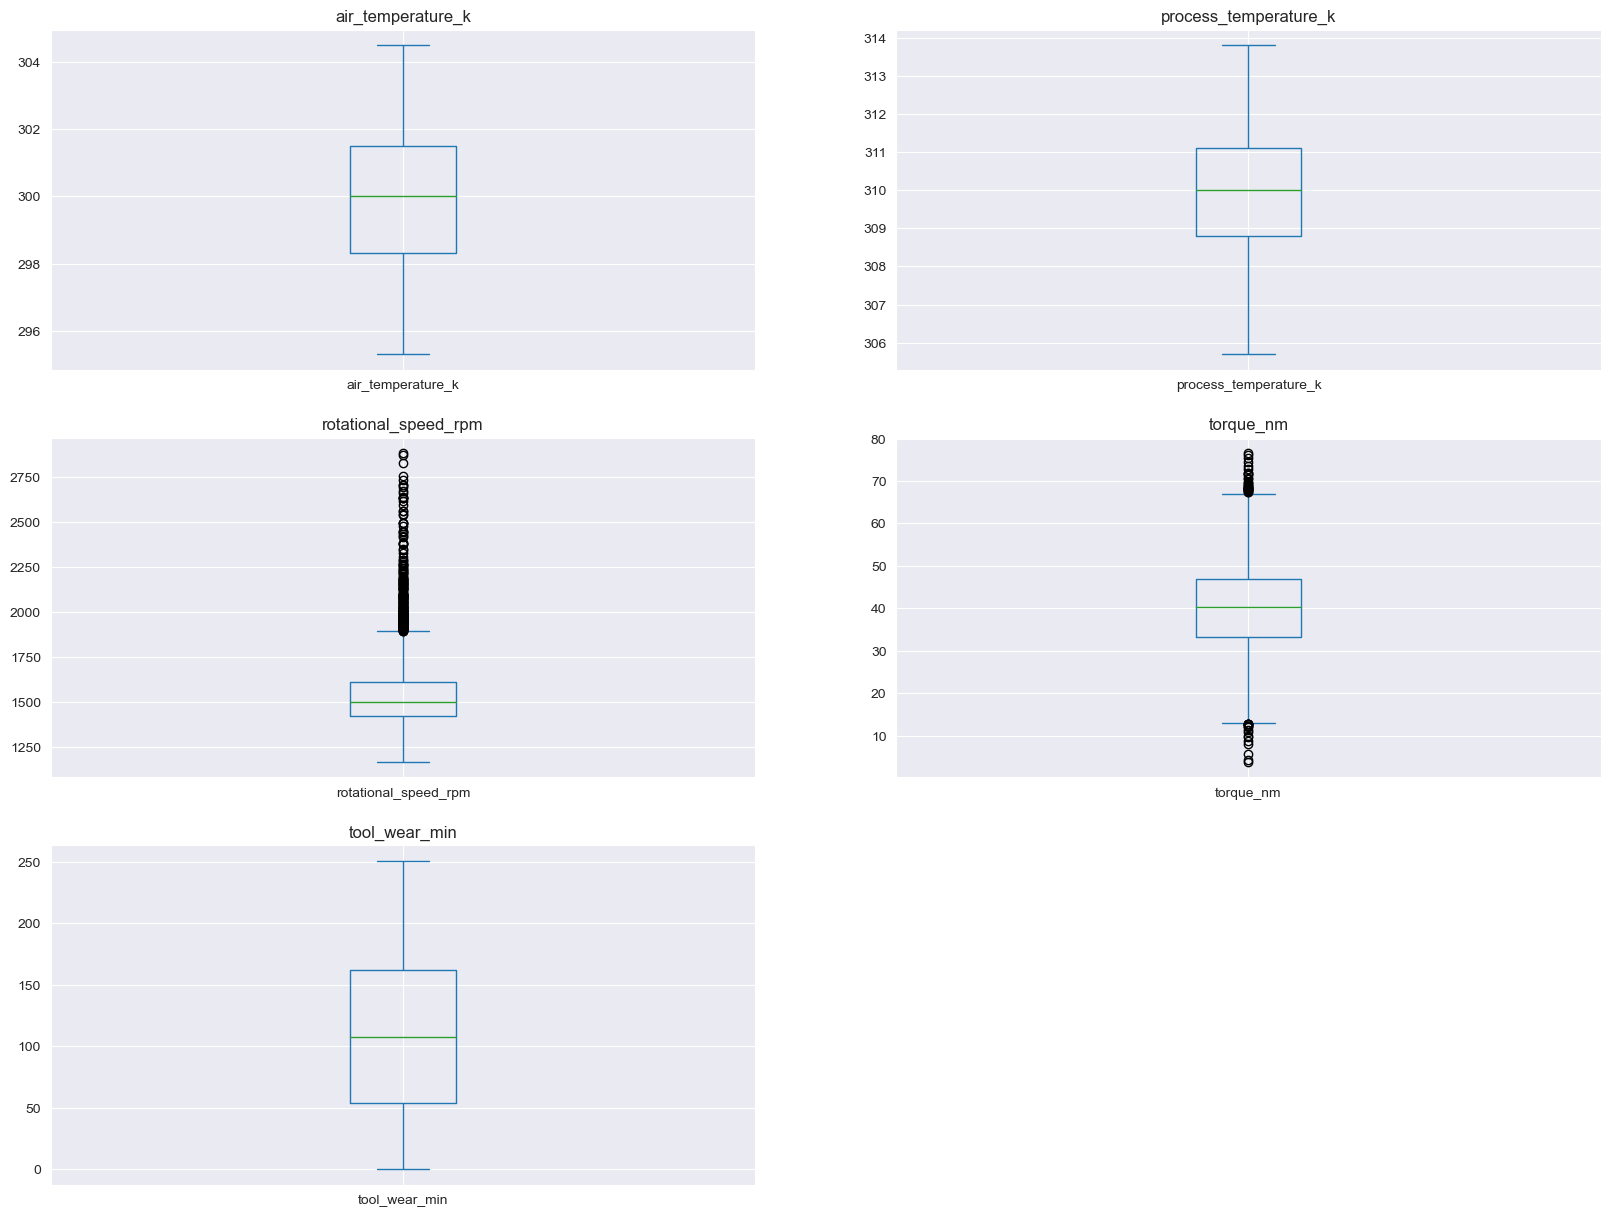

In [162]:
plot_boxplot(df_numericas)

In [ ]:
# Gráficos da biblioteca plotly express não estavam aparecendo, por isso foi necessário rodar esse cóigo abaixo
import plotly.io as pio
pio.renderers.default='notebook'

In [185]:
# Plotando gráficos de dispersão entre as colunas numéricas, com os registros de falhas coloridos
grafico = px.scatter_matrix(sensores_treino_df, dimensions=['air_temperature_k', 'process_temperature_k', 'rotational_speed_rpm',
       'torque_nm', 'tool_wear_min'], color = 'failure_type')
grafico.update_layout(
    autosize=False,
    width=1000,
    height=1000)
grafico.show()

In [186]:
df_apenas_falhas = sensores_treino_df[sensores_treino_df['failure_type'] != 'No Failure']
df_apenas_falhas

,udi,product_id,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type
52,70,L47249,L,298.9,309.0,1410,65.7,191,Power Failure
56,78,L47257,L,298.8,308.9,1455,41.3,208,Tool Wear Failure
112,161,L47340,L,298.4,308.2,1282,60.7,216,Overstrain Failure
113,162,L47341,L,298.3,308.1,1412,52.3,218,Overstrain Failure
143,208,M15067,M,298.4,308.7,1421,60.7,119,Power Failure
...,...,...,...,...,...,...,...,...,...
6440,9665,L56844,L,299.1,310.2,1317,54.8,231,Overstrain Failure
6442,9668,L56847,L,299.2,310.3,1352,48.9,238,Overstrain Failure
6501,9759,L56938,L,298.6,309.8,2271,16.2,218,Tool Wear Failure
6537,9823,L57002,L,298.5,309.4,1360,60.9,187,Overstrain Failure


In [187]:
df_categoricas = df_apenas_falhas.select_dtypes(exclude=['int64', 'float64'])
df_categoricas.head()

,product_id,type,failure_type
52,L47249,L,Power Failure
56,L47257,L,Tool Wear Failure
112,L47340,L,Overstrain Failure
113,L47341,L,Overstrain Failure
143,M15067,M,Power Failure


In [189]:
# Como as colunas "product_id" e type carregam a mesma informação, será usada apeanas 1 delas para análise
df_categoricas = df_categoricas.drop(columns='product_id')
df_categoricas.head()

,type,failure_type
52,L,Power Failure
56,L,Tool Wear Failure
112,L,Overstrain Failure
113,L,Overstrain Failure
143,M,Power Failure


In [190]:
contagem_tipos_maquinas = df_categoricas.groupby('type').count().reset_index()
contagem_tipos_maquinas.rename(columns= {'failure_type': 'contagem'}, inplace=True)
contagem_tipos_maquinas

,type,contagem
0,H,17
1,L,161
2,M,54


<AxesSubplot:title={'center':'Contagem do tipo de máquinas'}, xlabel='type'>

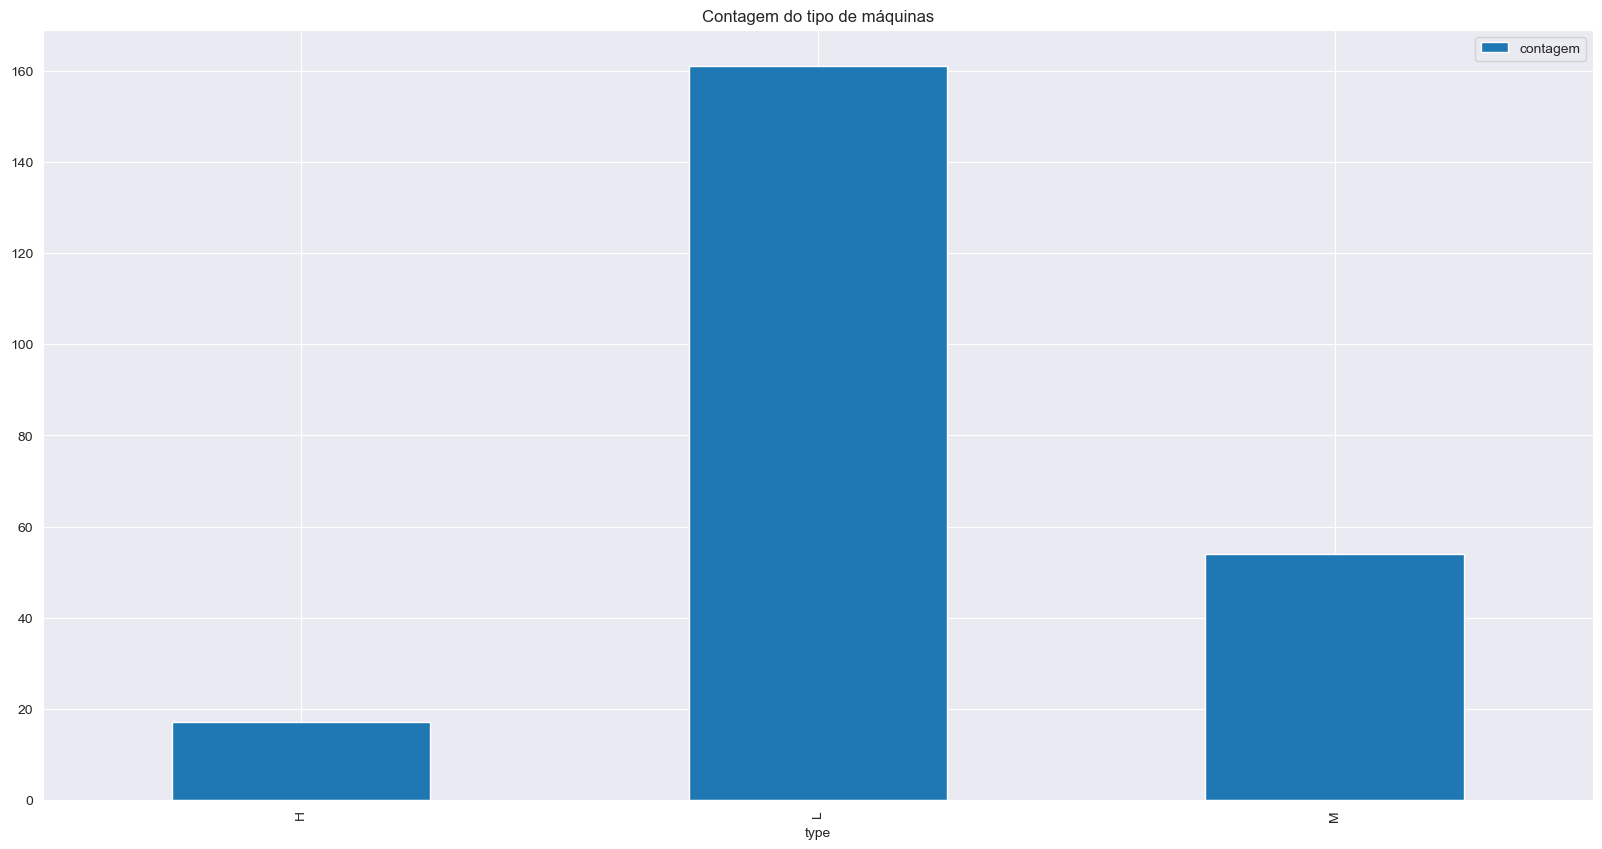

In [191]:
contagem_tipos_maquinas.plot(kind= 'bar', x= 'type', y='contagem', 
                             figsize= (20,10), title= 'Contagem do tipo de máquinas')

In [193]:
contagem_tipos_maquinas['proporções'] = contagem_tipos_maquinas['contagem']/232
contagem_tipos_maquinas

,type,contagem,proporções
0,H,17,0.073276
1,L,161,0.693966
2,M,54,0.232759


In [197]:
df_numericas = df_apenas_falhas.select_dtypes(include=['int64', 'float64'])
df_numericas.head()

,udi,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min
52,70,298.9,309.0,1410,65.7,191
56,78,298.8,308.9,1455,41.3,208
112,161,298.4,308.2,1282,60.7,216
113,162,298.3,308.1,1412,52.3,218
143,208,298.4,308.7,1421,60.7,119


In [198]:
df_numericas = df_numericas.drop(columns= 'udi')
df_numericas.head()

,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min
52,298.9,309.0,1410,65.7,191
56,298.8,308.9,1455,41.3,208
112,298.4,308.2,1282,60.7,216
113,298.3,308.1,1412,52.3,218
143,298.4,308.7,1421,60.7,119


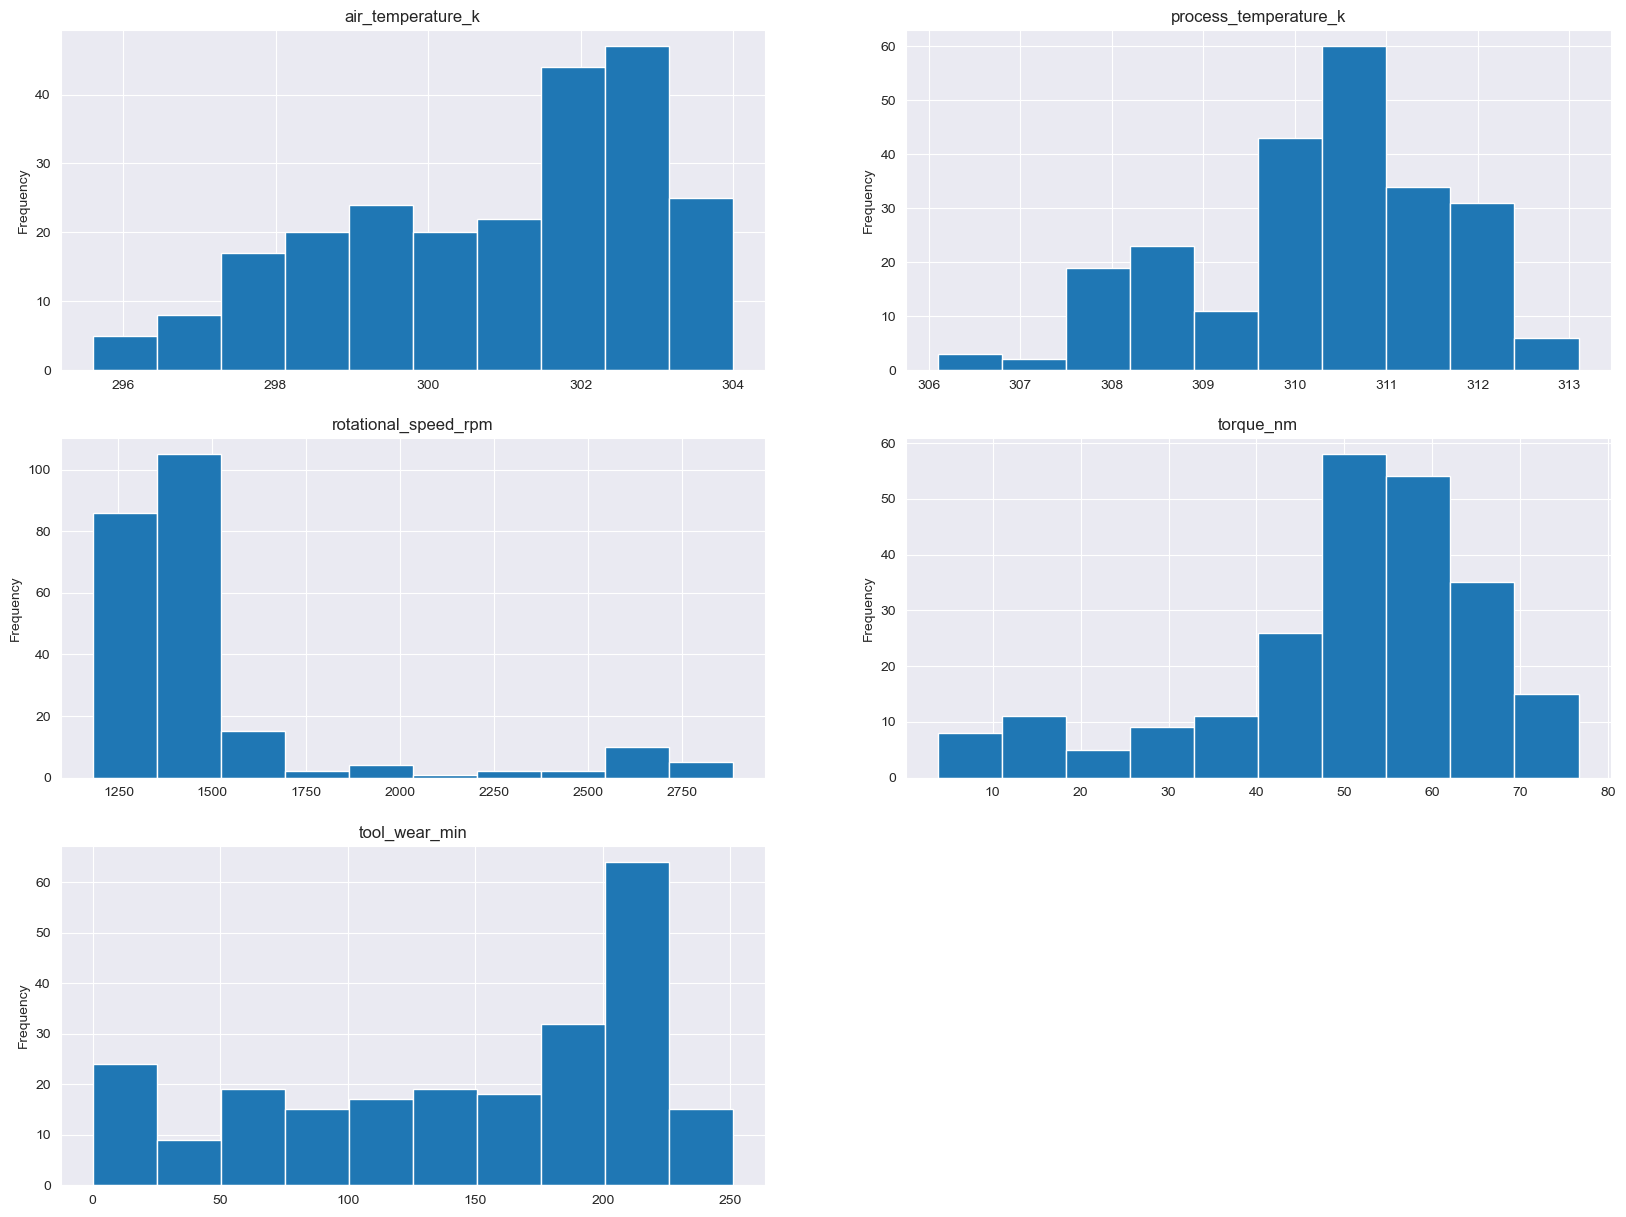

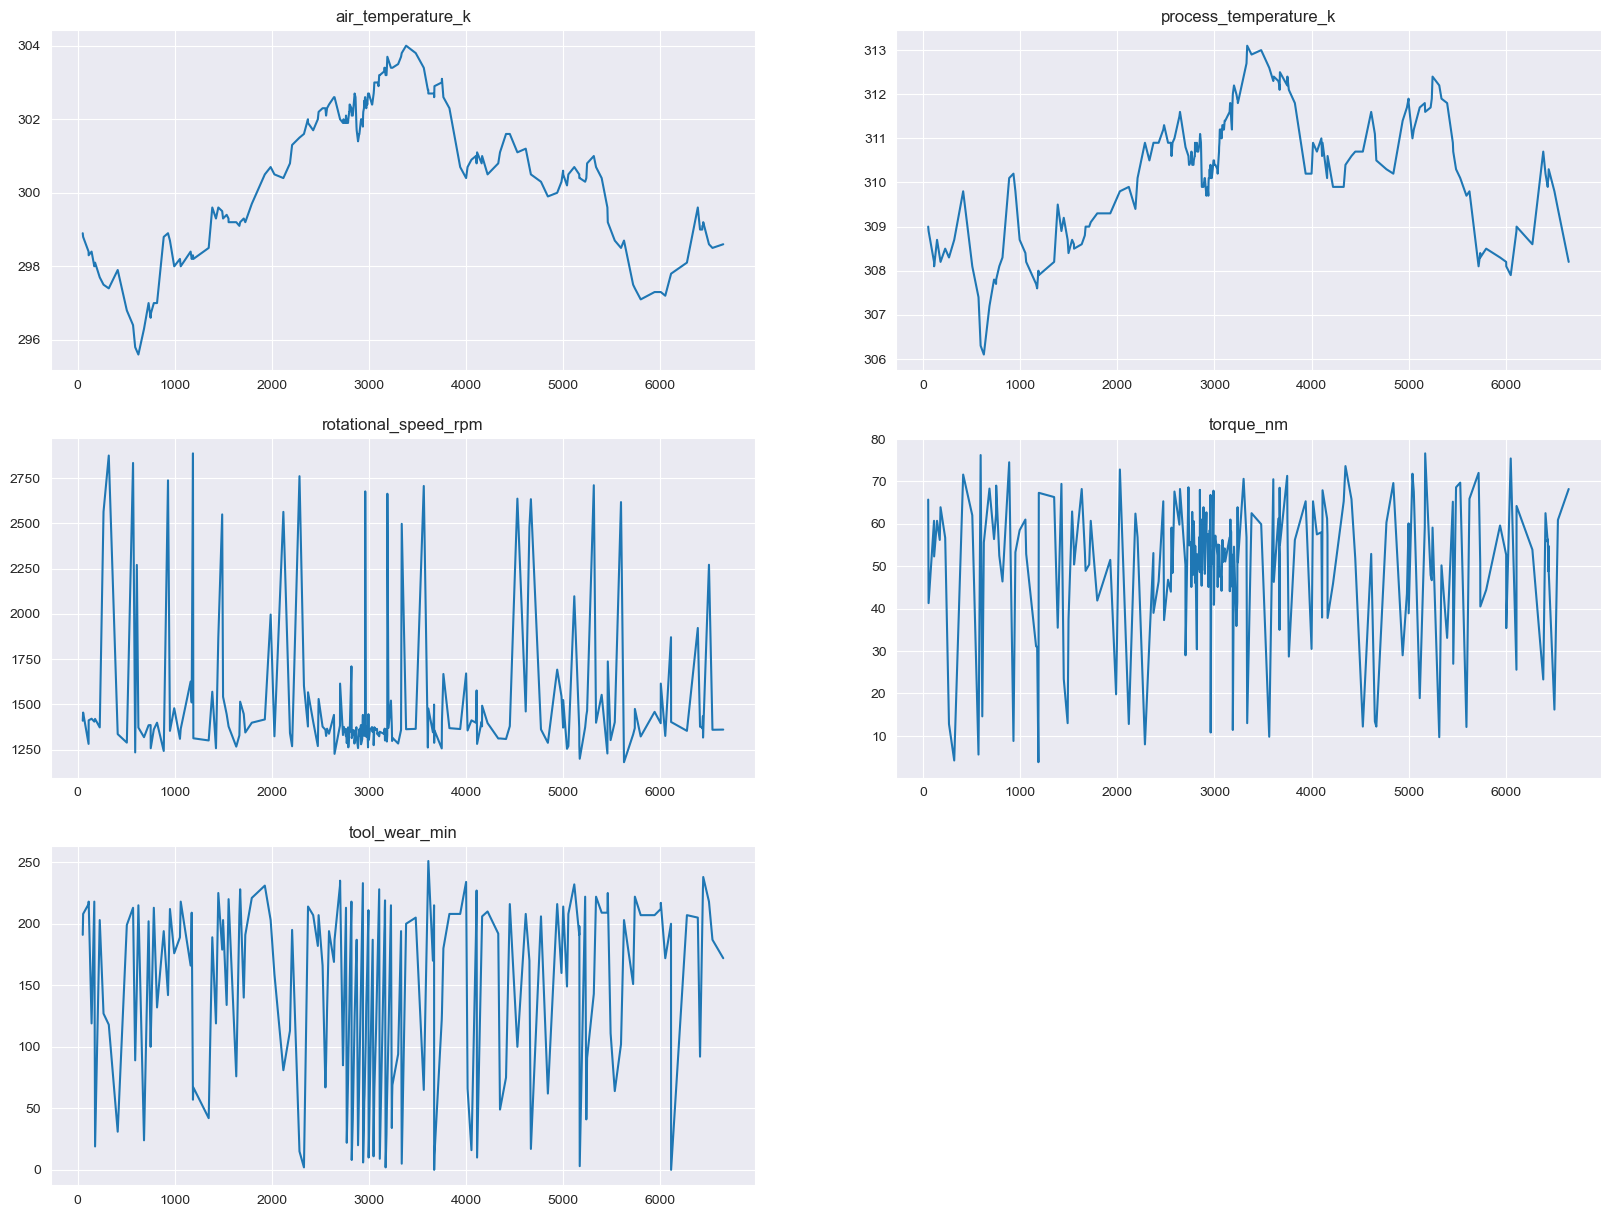

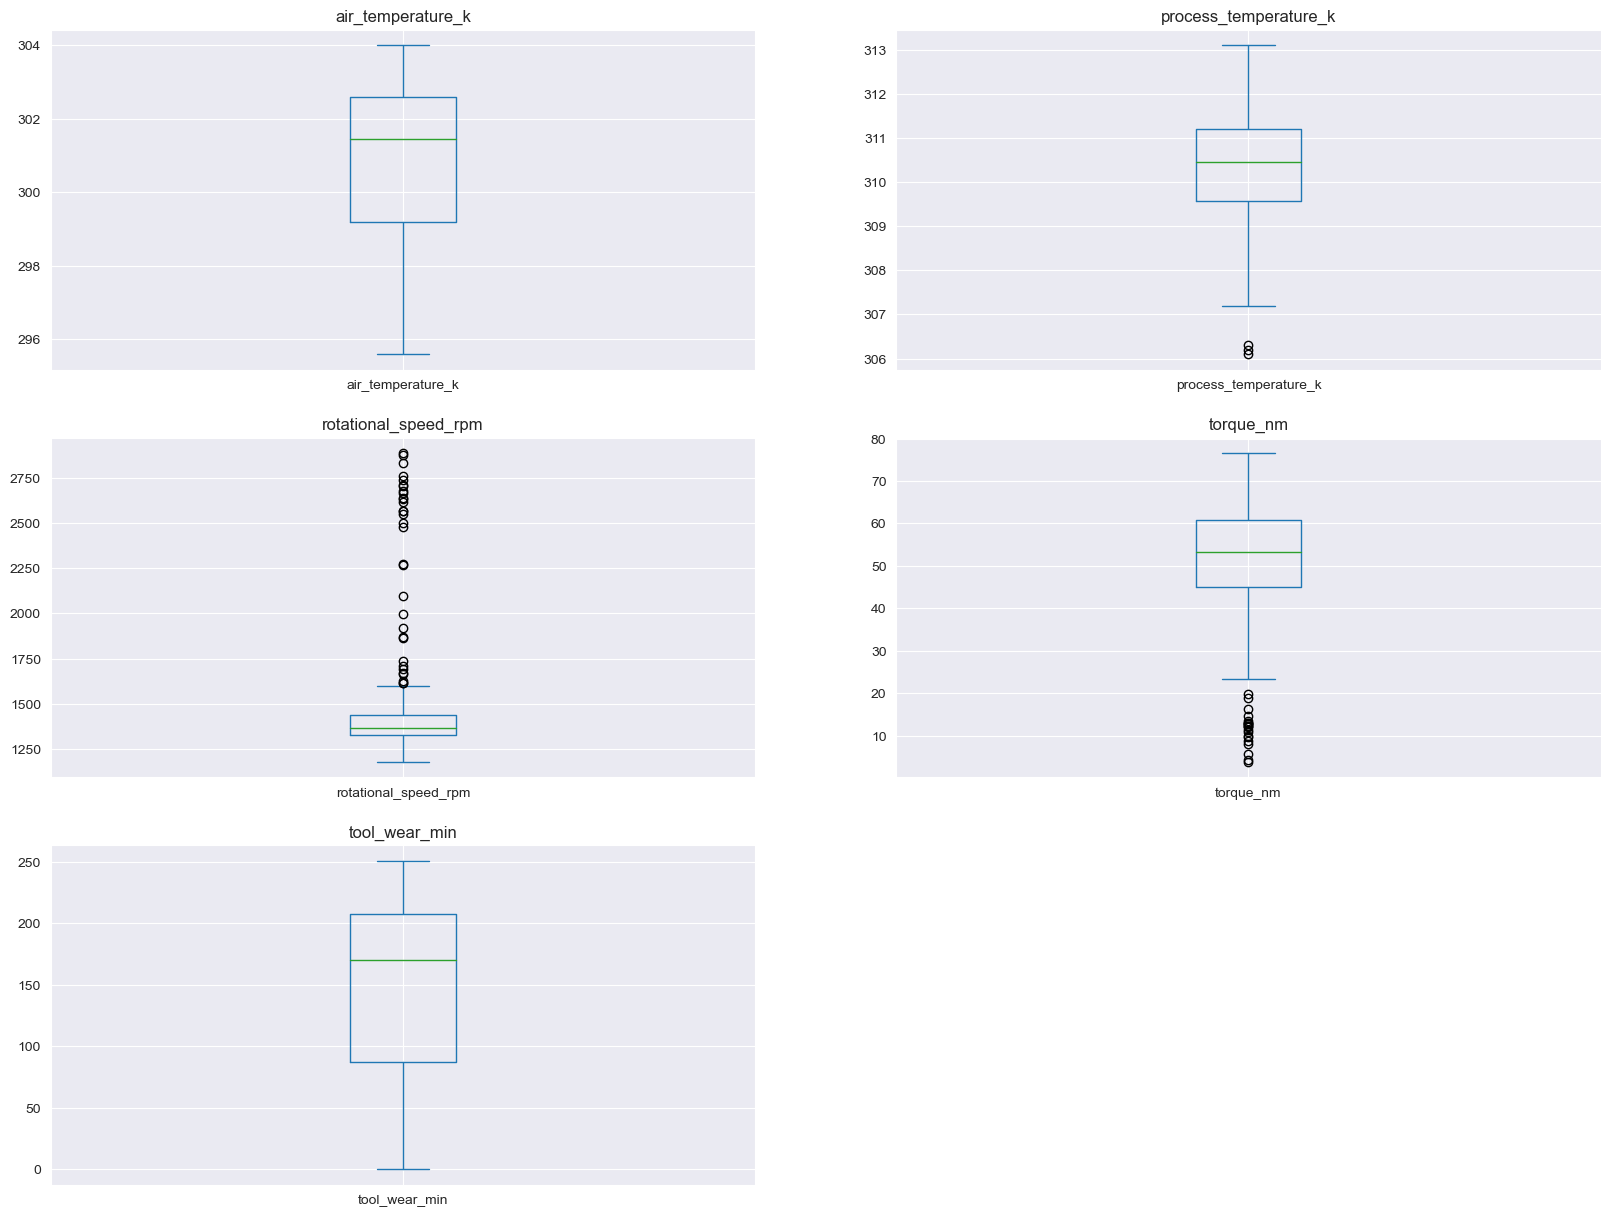

In [199]:
plot_hist(df_numericas)
plot_line(df_numericas)
plot_boxplot(df_numericas)

### 3.0 Preparação dos dados

In [247]:
sensores_treino_df

,udi,product_id,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type
0,1,M14860,M,298.1,308.6,1551,42.8,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,No Failure
2,5,L47184,L,298.2,308.7,1408,40.0,9,No Failure
3,6,M14865,M,298.1,308.6,1425,41.9,11,No Failure
4,7,L47186,L,298.1,308.6,1558,42.4,14,No Failure
...,...,...,...,...,...,...,...,...,...
6662,9995,L57174,L,298.8,308.3,1634,27.9,12,No Failure
6663,9996,M24855,M,298.8,308.4,1604,29.5,14,No Failure
6664,9997,H39410,H,298.9,308.4,1632,31.8,17,No Failure
6665,9999,H39412,H,299.0,308.7,1408,48.5,25,No Failure


In [248]:
df_dummies = pd.get_dummies(sensores_treino_df['type'])
sensores_treino_df = pd.concat([sensores_treino_df, df_dummies], axis=1)
sensores_treino_df

,udi,product_id,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type,H,L,M
0,1,M14860,M,298.1,308.6,1551,42.8,0,No Failure,0,0,1
1,2,L47181,L,298.2,308.7,1408,46.3,3,No Failure,0,1,0
2,5,L47184,L,298.2,308.7,1408,40.0,9,No Failure,0,1,0
3,6,M14865,M,298.1,308.6,1425,41.9,11,No Failure,0,0,1
4,7,L47186,L,298.1,308.6,1558,42.4,14,No Failure,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6662,9995,L57174,L,298.8,308.3,1634,27.9,12,No Failure,0,1,0
6663,9996,M24855,M,298.8,308.4,1604,29.5,14,No Failure,0,0,1
6664,9997,H39410,H,298.9,308.4,1632,31.8,17,No Failure,1,0,0
6665,9999,H39412,H,299.0,308.7,1408,48.5,25,No Failure,1,0,0


In [478]:
X = sensores_treino_df.drop(columns=['udi', 'type', 'product_id', 'failure_type']).values
y = sensores_treino_df['failure_type'].values

In [472]:
falhas = list(np.unique(y, return_counts=True)[0])
falhas

['Heat Dissipation Failure',
 'No Failure',
 'Overstrain Failure',
 'Power Failure',
 'Random Failures',
 'Tool Wear Failure']

In [473]:
n_amostras = list(np.unique(y, return_counts=True)[1])
n_amostras

[75, 6435, 52, 63, 12, 30]

In [468]:
df = pd.DataFrame(X_over, columns = sensores_treino_df.drop(columns=['udi', 'type', 'product_id', 'failure_type']).columns)
df1 = pd.DataFrame(y_over, columns = ['failure_type'])
df2 = pd.concat([df, df1], axis=1)
df2

,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,H,L,M,failure_type
0,298.100000,308.600000,1551.000000,42.800000,0.000000,0.00000,0.000000,1.000000,No Failure
1,298.200000,308.700000,1408.000000,46.300000,3.000000,0.00000,1.000000,0.000000,No Failure
2,298.200000,308.700000,1408.000000,40.000000,9.000000,0.00000,1.000000,0.000000,No Failure
3,298.100000,308.600000,1425.000000,41.900000,11.000000,0.00000,0.000000,1.000000,No Failure
4,298.100000,308.600000,1558.000000,42.400000,14.000000,0.00000,1.000000,0.000000,No Failure
...,...,...,...,...,...,...,...,...,...
6894,302.549313,311.503766,1527.380153,36.892468,209.328752,0.00000,1.000000,0.000000,Tool Wear Failure
6895,301.055554,309.814530,1416.230731,45.643590,219.829040,0.57265,0.427350,0.000000,Tool Wear Failure
6896,302.156383,311.241844,1535.379474,37.547165,208.017738,0.00000,1.000000,0.000000,Tool Wear Failure
6897,300.935425,309.794170,1418.354990,41.488192,216.881917,0.00000,0.411808,0.588192,Tool Wear Failure


In [479]:
for i in range(2,30,2):
    falhas
    n_amostras = list(np.unique(y, return_counts=True)[1])
    n_amostras = [k * i for k in n_amostras]
    strategy = dict(zip(falhas, n_amostras))
    strategy['No Failure'] = 6435
    print(strategy)
    
    smote = SMOTE(sampling_strategy=strategy)
    X_over, y_over = smote.fit_resample(X, y)
    
    df = pd.DataFrame(X_over, columns = sensores_treino_df.drop(columns=['udi', 'type', 'product_id', 'failure_type']).columns)
    df1 = pd.DataFrame(y_over, columns = ['failure_type'])
    df2 = pd.concat([df, df1], axis=1)
    
    split = StratifiedShuffleSplit(test_size=0.3)
    for a, b in split.split(df2, df2['failure_type']):
        train = df2.iloc[a]
        test = df2.iloc[b]
    #X_train, X_test, y_train, y_test = train_test_split(X_over, y_over,test_size=0.4, shuffle=False)
    X_train = train.drop(columns= ['failure_type']).values
    y_train = train['failure_type'].values
    X_test = test.drop(columns= ['failure_type']).values
    y_test = test['failure_type'].values
    xgb = XGBClassifier()
    xgb.fit(X_train,y_train)
    
    print(classification_report(y_test, xgb.predict(X_test)))   

{'Heat Dissipation Failure': 150, 'No Failure': 6435, 'Overstrain Failure': 104, 'Power Failure': 126, 'Random Failures': 24, 'Tool Wear Failure': 60}
                          precision    recall  f1-score   support

Heat Dissipation Failure       0.95      0.91      0.93        45
              No Failure       0.98      1.00      0.99      1931
      Overstrain Failure       0.76      0.71      0.73        31
           Power Failure       0.91      0.82      0.86        38
         Random Failures       1.00      0.14      0.25         7
       Tool Wear Failure       0.86      0.33      0.48        18

                accuracy                           0.98      2070
               macro avg       0.91      0.65      0.71      2070
            weighted avg       0.98      0.98      0.98      2070

{'Heat Dissipation Failure': 300, 'No Failure': 6435, 'Overstrain Failure': 208, 'Power Failure': 252, 'Random Failures': 48, 'Tool Wear Failure': 120}
                          precisio

In [436]:
X_train, X_test, y_train, y_test = train_test_split(X_under, y_under,test_size=0.3, shuffle=False)

In [437]:
print('X_train Observations: %d' % (len(X_train)))
print('y_train Observations: %d' % (len(y_train)))

print('X_test Observations: %d' % (len(X_test)))
print('y_test Observations: %d' % (len(y_test)))

X_train Observations: 4616
y_train Observations: 4616
X_test Observations: 1979
y_test Observations: 1979


In [438]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)

XGBClassifier(objective='multi:softprob')

In [439]:
print(classification_report(y_test, xgb.predict(X_test)))

                    precision    recall  f1-score   support

        No Failure       0.99      1.00      0.99      1933
Overstrain Failure       0.88      0.82      0.85        17
     Power Failure       0.92      0.80      0.86        15
   Random Failures       0.00      0.00      0.00         2
 Tool Wear Failure       0.00      0.00      0.00        12

          accuracy                           0.99      1979
         macro avg       0.56      0.52      0.54      1979
      weighted avg       0.98      0.99      0.98      1979



C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [413]:
params = {'max_depth':range(4,7),
          'min_child_weight':[2,3,4,5,6],
          'n_estimators':[50, 70, 100, 150,180, 200],
          'gamma':[i/10.0 for i in range(0,5)],
          'subsample':[i/10.0 for i in range(6,10)],
          'colsample_bytree':[i/10.0 for i in range(6,10)],
          'learning_rate':[0.05,0.1,0.15,0.2]}

xgb = XGBClassifier(random_state=1)

random_search_xgb = RandomizedSearchCV(xgb, params, n_iter=100, cv=10, random_state=1, n_jobs=-1)
random_search_xgb.fit(X_train,y_train)

RandomizedSearchCV(cv=10, estimator=XGBClassifier(random_state=1), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8,
                                                             0.9],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2],
                                        'max_depth': range(4, 7),
                                        'min_child_weight': [2, 3, 4, 5, 6],
                                        'n_estimators': [50, 70, 100, 150, 180,
                                                         200],
                                        'subsample': [0.6, 0.7, 0.8, 0.9]},
                   random_state=1)

In [225]:
print(" Results from Random Search " )
print("\n The best estimator across ALL searched params:\n", random_search_xgb.best_estimator_)
print("\n The best score across ALL searched params:\n", random_search_xgb.best_score_)
print("\n The best parameters across ALL searched params:\n", random_search_xgb.best_params_)

 Results from Random Search 

 The best estimator across ALL searched params:
 XGBClassifier(colsample_bytree=0.9, gamma=0.0, learning_rate=0.05, max_depth=5,
              min_child_weight=3, n_estimators=150, objective='multi:softprob',
              random_state=1, subsample=0.8)

 The best score across ALL searched params:
 0.974119358306807

 The best parameters across ALL searched params:
 {'subsample': 0.8, 'n_estimators': 150, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.0, 'colsample_bytree': 0.9}


In [412]:
xgb = XGBClassifier(subsample= 0.8, n_estimators= 150, 
                    min_child_weight= 3, max_depth= 5, learning_rate= 0.05, gamma= 0.0, colsample_bytree= 0.9)
xgb.fit(X_train,y_train)
print(classification_report(y_test, xgb.predict(X_test)))

                          precision    recall  f1-score   support

Heat Dissipation Failure       0.99      0.94      0.97       175
              No Failure       0.72      1.00      0.84      1260
      Overstrain Failure       0.99      0.94      0.97       209
           Power Failure       0.98      0.94      0.96       196
         Random Failures       0.00      0.00      0.00       238
       Tool Wear Failure       1.00      0.07      0.12       228

                accuracy                           0.79      2306
               macro avg       0.78      0.65      0.64      2306
            weighted avg       0.74      0.79      0.71      2306



C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [446]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(test_size=0.3)
for x, y in split.split(sensores_treino_df, sensores_treino_df['failure_type']):
    train = sensores_treino_df.iloc[x]
    test = sensores_treino_df.iloc[y]

In [447]:
test['failure_type'].value_counts()/test['failure_type'].shape

No Failure                  0.965017
Heat Dissipation Failure    0.010995
Power Failure               0.009495
Overstrain Failure          0.007996
Tool Wear Failure           0.004498
Random Failures             0.001999
Name: failure_type, dtype: float64

In [448]:
train['failure_type'].value_counts()/train['failure_type'].shape

No Failure                  0.965281
Heat Dissipation Failure    0.011359
Power Failure               0.009430
Overstrain Failure          0.007715
Tool Wear Failure           0.004501
Random Failures             0.001715
Name: failure_type, dtype: float64

In [449]:
train

,udi,product_id,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type,H,L,M
4510,6773,L53952,L,301.3,310.7,1536,39.3,31,No Failure,0,1,0
3545,5311,L52490,L,303.8,313.0,1427,43.0,0,No Failure,0,1,0
3643,5450,L52629,L,303.1,312.8,2329,15.1,113,No Failure,0,1,0
1905,2825,M17684,M,300.3,309.5,1448,42.4,145,No Failure,0,0,1
721,1071,M15930,M,296.9,307.8,1477,37.2,160,No Failure,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2282,3368,H32781,H,301.5,310.7,1790,26.2,8,No Failure,1,0,0
2584,3851,M18710,M,302.3,311.0,1421,41.3,182,No Failure,0,0,1
4963,7459,M22318,M,300.1,311.6,1433,51.4,76,No Failure,0,0,1
4140,6219,H35632,H,301.0,310.6,1366,50.6,106,No Failure,1,0,0


In [450]:
X_train = train.drop(columns= ['udi', 'product_id', 'type', 'failure_type']).values
y_train = train['failure_type'].values
X_test = test.drop(columns= ['udi', 'product_id', 'type', 'failure_type']).values
y_test = test['failure_type'].values

In [451]:
xgb = XGBClassifier(subsample= 0.8, n_estimators= 150, 
                    min_child_weight= 3, max_depth= 5, learning_rate= 0.05, gamma= 0.0, colsample_bytree= 0.9)
xgb.fit(X_train,y_train)
print(classification_report(y_test, xgb.predict(X_test)))

                          precision    recall  f1-score   support

Heat Dissipation Failure       0.86      0.86      0.86        22
              No Failure       0.99      1.00      0.99      1931
      Overstrain Failure       1.00      0.88      0.93        16
           Power Failure       0.76      0.84      0.80        19
         Random Failures       0.00      0.00      0.00         4
       Tool Wear Failure       0.00      0.00      0.00         9

                accuracy                           0.99      2001
               macro avg       0.60      0.60      0.60      2001
            weighted avg       0.98      0.99      0.98      2001



C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
#Validação cruzada
resultados_xgb = pd.DataFrame()

for i in range(30):
    print(i)
    kfold = KFold(n_splits=10, shuffle=True, random_state=i)

    # Validação XGBoost
    xgb = XGBClassifier(colsample_bytree=0.7, gamma=0.0, max_depth=5, min_child_weight=4,
          n_estimators=200, objective='multi:softprob', random_state=k,
          subsample=0.9)
    xgb.fit(X_train,y_train)
    metricas = classification_report(y_test, xgb.predict(X_test), digits = 4, output_dict=True)
    resultados_xgb = resultados_xgb.append(pd.DataFrame(metricas).transpose().reset_index(), ignore_index=True)

print('Resultados XGBoost Passo {}'.format(k))
display(resultados_xgb)